#**Capstone Project - Analysis of Rio de Janeiro's Centro venues**

## Table of contents
* [Introduction](#introduction)
* [Importing libraries and initial data gathering](#initial)
* [Collecting, processing and starting to visualize data](#collecting)
* [Using Silhouete and Elbow to find the best k](#metrics)
* [Clean visuals for our clusters & final mapping](#visuals)
* [What can we understand from the data?](#conclusion)

##**1 - Introduction**<a name="introduction"></a>

In this project I will be using the Foursquare API to explore and analyse different venues on Rio de Janeiro's Centro, a neighborhood known as the heart of business in the city, also home of some of the most important Museums and restaurants in the city. The idea is to provide information that could help a tourist vising the city to choose the best hotel to stay, based on the locations they decide to visit within walking distance and other preferences.

##**2 - Importing libraries and initial data gathering**<a name="initial"></a>

here are some of the most important python libraries used on this project:

In [ ]:
import requests
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#!pip install geopy # remove the comment to install if necessary
from geopy.geocoders import Nominatim

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

#! pip install folium==0.5.0 # remove the comment to install if necessary
import folium

print('Libraries imported.')

Libraries imported.


Foursquare API requests 3 different user keys when making calls to their database, the Client ID, the Client Secret and the Access Token. Those are all listed below, and since its also required for us to provide the version of the API we are trying to access, it will be listed here aswell, together with a initial queries Limit value.

In [ ]:
CLIENT_ID = '#my Foursquare ID'
CLIENT_SECRET = '#my Foursquare Secret' 
ACCESS_TOKEN = '#my FourSquare Access Token' 
VERSION = 20180604
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 1QQCADPYRVDCFII0L3TQQKJNHDCHTXETVHHAHLQ3VEXZI1HQ
CLIENT_SECRET:B1KIFVQLWSRCUY2OLRZBHCQWOSATB2O41L2NQGUNX3INJE54


Here we are using the geolocator to provide coordinates used as starting point for data collection. Santos Dumont Airport was chosen for its tourist traffic and we'll expand from there. 

In [ ]:
address = 'Aeroporto Santos Dumont, Centro, Rio de Janeiro, RJ'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-22.91071875 -43.164178244974906


Here we're choosing 'Hotel' as our search query, which will return all hotels on a 8km radius from the airport. After the data preparation, we'll plot on a map using Folium to see if we can use them as base our data analysis.

In [ ]:
search_query = 'Hotel'
radius = 8000

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

hoteis = results['response']['venues']
df_venues = json_normalize(hoteis)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


As you can see below, the data was sucessfully pulled, transformed into a dataframe using pandas, but it's full of unnecessary information for our current objective:

In [ ]:
df_venues.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,58bdfa760e0a1e57cf5b2154,Rooftop Prodigy Hotel,"[{'id': '4bf58dd8d48988d133951735', 'name': 'R...",v-1619122665,False,Prodigy Hotel,-22.914156,-43.167154,"[{'label': 'display', 'lat': -22.9141560049783...",489,20021-010,BR,Rio de Janeiro,RJ,Brasil,"[Prodigy Hotel, Rio de Janeiro, RJ, 20021-010]",NaN
1,4baa6677f964a5208e663ae3,ibis Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619122665,False,"Av. Mal. Câmara, 280",-22.908463,-43.169472,"[{'label': 'display', 'lat': -22.9084633275061...",598,20020-080,BR,Rio de Janeiro,RJ,Brasil,"[Av. Mal. Câmara, 280, Rio de Janeiro, RJ, 200...",NaN
2,4b058720f964a520ef8022e3,Hotel Aeroporto Othon,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619122665,False,"Av. Beira Mar, 280",-22.910789,-43.171091,"[{'label': 'display', 'lat': -22.9107894562650...",708,20021-060,BR,Rio de Janeiro,RJ,Brasil,"[Av. Beira Mar, 280, Rio de Janeiro, RJ, 20021...",NaN
3,4d88150f5ecdf04d42cf8f8a,Hotel Atlântico Business,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619122665,False,"R. Sen. Dantas, 25",-22.911436,-43.176698,"[{'label': 'display', 'lat': -22.9114356762324...",1286,20031-202,BR,Rio de Janeiro,RJ,Brasil,"[R. Sen. Dantas, 25, Rio de Janeiro, RJ, 20031...",NaN
4,5912388e9de23b2ae27a53db,Hotel Demoiselle,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619122665,False,Clube de Aeronáutica,-22.905169,-43.168137,"[{'label': 'display', 'lat': -22.905169, 'lng'...",739,20021-200,BR,Rio de Janeiro,RJ,Brasil,"[Clube de Aeronáutica, Rio de Janeiro, RJ, 200...",NaN


Let's clean this dataframe a bit by creating a new one with only the useful columns, rename them and and proceed exploring our data:

In [ ]:
df_hoteis = pd.DataFrame([df_venues['name'],df_venues['location.lat'],df_venues['location.lng'],df_venues['location.distance']])
df_hoteis = df_hoteis.transpose()
df_hoteis['category']='Hotel'
df_hoteis.rename(columns={'location.lat':'latitude','location.lng':'longitude','location.distance':'distance'}, inplace=True)

In [ ]:
print(df_hoteis.info())
print(df_hoteis.shape)
df_hoteis.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       30 non-null     object
 1   latitude   30 non-null     object
 2   longitude  30 non-null     object
 3   distance   30 non-null     object
 4   category   30 non-null     object
dtypes: object(5)
memory usage: 1.3+ KB
None
(30, 5)


,name,latitude,longitude,distance,category
0,Rooftop Prodigy Hotel,-22.9142,-43.1672,489,Hotel
1,ibis Hotel,-22.9085,-43.1695,598,Hotel
2,Hotel Aeroporto Othon,-22.9108,-43.1711,708,Hotel
3,Hotel Atlântico Business,-22.9114,-43.1767,1286,Hotel
4,Hotel Demoiselle,-22.9052,-43.1681,739,Hotel
5,Hotel Atlântico Tower,-22.9003,-43.1799,1988,Hotel
6,Hotel Santa Teresa,-22.9216,-43.1875,2684,Hotel
7,Hotel Novo Mundo,-22.9255,-43.1731,1879,Hotel
8,Itajubá Hotel,-22.9114,-43.1762,1231,Hotel
9,Golden Park Hotel,-22.9219,-43.1741,1605,Hotel


##**3 - Collecting, Processing and starting to visualize data**<a name="collecting"></a>


We've done our initial data cleanup, so I think we are ready to start visualizing our starting point on the airport and nearby hotels:

In [ ]:
airport_lat = -22.91071875
airport_lon = -43.164178244974906

map_centro = folium.Map(location=[airport_lat, airport_lon],zoom_start=15)

folium.CircleMarker(
                    [airport_lat, airport_lon],
                    radius=10,
                    popup='Santos Dumont Airport',
                    fill=True,
                    color='red',
                    fill_color='red',
                    fill_opacity=0.6).add_to(map_centro)
map_centro

In [ ]:
map_centro_hoteis = folium.Map(location=[airport_lat, airport_lon],zoom_start=15)

for lat, lon, name in zip(df_hoteis['latitude'],df_hoteis['longitude'],df_hoteis['name']):
    label = '{}'.format(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='yellow',
        fill_opacity=0.5
        ).add_to(map_centro_hoteis)

map_centro_hoteis

### **3.1 - Collecting venues data**

Looks like the initial data is plotting correctly, so we can move on and start getting more interesting data from Foursquare API, like restaurants, bars and museums. We can repeat the search, data gathering and cleanup we did for our hotels with other venues:

Collecting restaurants and food venues data and adding related category column:

In [ ]:
search_query = 'food'
limit_places = 100

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, limit_places)
results = requests.get(url).json()

food = results['response']['venues']
df_food = json_normalize(food)

df_food['category']='Food'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [ ]:
print(df_food.info())
print(df_food.shape)
df_food.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50 non-null     object 
 1   name                       50 non-null     object 
 2   categories                 50 non-null     object 
 3   referralId                 50 non-null     object 
 4   hasPerk                    50 non-null     bool   
 5   location.address           29 non-null     object 
 6   location.lat               50 non-null     float64
 7   location.lng               50 non-null     float64
 8   location.labeledLatLngs    50 non-null     object 
 9   location.distance          50 non-null     int64  
 10  location.postalCode        18 non-null     object 
 11  location.cc                50 non-null     object 
 12  location.city              36 non-null     object 
 13  location.state             37 non-null     object 
 

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,category
0,57e59302498e6a859d6dd2df,Mr. Fit Fast Food Saudável,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1619122666,False,"Av. Mal. Floriano, 127",-22.909987,-43.171241,"[{'label': 'display', 'lat': -22.909987, 'lng'...",728,20080-005,BR,Rio de Janeiro,RJ,Brasil,"[Av. Mal. Floriano, 127, Rio de Janeiro, RJ, 2...",NaN,Food
1,56427127498e4309fc73811e,Joe's Pub Food Truck,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",v-1619122666,False,R. do Catete,-22.926608,-43.176610,"[{'label': 'display', 'lat': -22.9266075299422...",2180,NaN,BR,Rio de Janeiro,RJ,Brasil,"[R. do Catete, Rio de Janeiro, RJ]",NaN,Food
2,5e5bf05498c49900087f5703,Vou Street Food,"[{'id': '52939a643cf9994f4e043a33', 'name': 'C...",v-1619122666,False,Bossa Nova Mall (Praça De Alimentação),-22.914657,-43.166351,"[{'label': 'display', 'lat': -22.914657, 'lng'...",491,20021-010,BR,Rio de Janeiro,RJ,Brasil,"[Bossa Nova Mall (Praça De Alimentação), Rio d...",NaN,Food
3,5f5f6c9624ae6f671d9fe64b,Kitchen Asian Food,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1619122666,False,Marina da Glória,-22.920310,-43.170498,"[{'label': 'display', 'lat': -22.92031, 'lng':...",1248,20021-140,BR,NaN,Rio de Janeiro,Brasil,"[Marina da Glória, Rio de Janeiro, 20021-140]",NaN,Food
4,55d34ae5498e9a38dae27fb8,Mix Folhas Fresh Food,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",v-1619122666,False,NaN,-22.905122,-43.173773,"[{'label': 'display', 'lat': -22.9051218480648...",1164,NaN,BR,NaN,NaN,Brasil,NaN,NaN,Food


Collecting Coffee shops data and adding related category column:

In [ ]:
search_query = 'coffee'
limit_places = 100

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, limit_places)

results = requests.get(url).json()

coffee = results['response']['venues']
df_coffee = json_normalize(coffee)

df_coffee['category'] ='Coffee'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [ ]:
print(df_coffee.info())
print(df_coffee.shape)
df_coffee.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50 non-null     object 
 1   name                       50 non-null     object 
 2   categories                 50 non-null     object 
 3   referralId                 50 non-null     object 
 4   hasPerk                    50 non-null     bool   
 5   location.address           41 non-null     object 
 6   location.crossStreet       12 non-null     object 
 7   location.lat               50 non-null     float64
 8   location.lng               50 non-null     float64
 9   location.labeledLatLngs    50 non-null     object 
 10  location.distance          50 non-null     int64  
 11  location.postalCode        28 non-null     object 
 12  location.cc                50 non-null     object 
 13  location.city              40 non-null     object 
 

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,category
0,5820a476afe10172680d5392,Gastrô Coffee Break,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1619122666,False,"R. Costas Bastos, 55",R. Riachuelo,-22.914346,-43.190035,"[{'label': 'display', 'lat': -22.9143456263784...",2681,20240-020,BR,Rio de Janeiro,RJ,Brasil,"[R. Costas Bastos, 55 (R. Riachuelo), Rio de J...",NaN,Coffee
1,56a48b6a498e29423d33fa46,Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1619122666,False,Centro,NaN,-22.909108,-43.180282,"[{'label': 'display', 'lat': -22.9091079583458...",1660,NaN,BR,Rio de Janeiro,RJ,Brasil,"[Centro, Rio de Janeiro, RJ]",NaN,Coffee
2,5ab0598b4928141356fed631,Coffee Five,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1619122666,False,Galeria Sul América,NaN,-22.902638,-43.176640,"[{'label': 'display', 'lat': -22.9026375708899...",1562,20091-902,BR,Rio de Janeiro,RJ,Brasil,"[Galeria Sul América, Rio de Janeiro, RJ, 2009...",NaN,Coffee
3,4bcb4834fb84c9b64e7e1e3e,Califórnia Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1619122666,False,Plaza Shopping,3º Piso,-22.896481,-43.123499,"[{'label': 'display', 'lat': -22.8964810893923...",4462,24020-125,BR,Niterói,RJ,Brasil,"[Plaza Shopping (3º Piso), Niterói, RJ, 24020-...","Centro, Niterói, RJ",Coffee
4,50880434e4b05e0a9439896a,Brasas Coffee Shop,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1619122666,False,Av. Graça Aranha,NaN,-22.909952,-43.174132,"[{'label': 'display', 'lat': -22.9099519183639...",1024,NaN,BR,Rio de Janeiro,RJ,Brasil,"[Av. Graça Aranha, Rio de Janeiro, RJ]",NaN,Coffee


Collecting Bars and drinks venues data and adding related category column:

In [ ]:
search_query = 'bar'
limit_places = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, limit_places)

results = requests.get(url).json()

drinks = results['response']['venues']
df_drinks = json_normalize(drinks)

df_drinks['category'] = 'Drinks'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [ ]:
print(df_drinks.info())
print(df_drinks.shape)
df_drinks.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50 non-null     object 
 1   name                       50 non-null     object 
 2   categories                 50 non-null     object 
 3   referralId                 50 non-null     object 
 4   hasPerk                    50 non-null     bool   
 5   location.address           44 non-null     object 
 6   location.crossStreet       13 non-null     object 
 7   location.lat               50 non-null     float64
 8   location.lng               50 non-null     float64
 9   location.labeledLatLngs    50 non-null     object 
 10  location.distance          50 non-null     int64  
 11  location.postalCode        33 non-null     object 
 12  location.cc                50 non-null     object 
 13  location.city              49 non-null     object 
 

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id,category
0,4cc9a7b3bcb1b1f7bc94108a,Bar e Restaurante 14 Bis,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1619122667,False,"2º Piso, Terminal de Embarque",Aeroporto Santos Dumont,-22.913257,-43.166816,"[{'label': 'display', 'lat': -22.9132567464224...",391,20021-340,BR,Rio de Janeiro,RJ,Brasil,"[2º Piso, Terminal de Embarque (Aeroporto Sant...",NaN,NaN,Drinks
1,4fa3e161e4b09d4d446293c5,Bar,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",v-1619122667,False,ibis Hotel,NaN,-22.908489,-43.169628,"[{'label': 'display', 'lat': -22.9084890394431...",611,NaN,BR,Rio de Janeiro,RJ,Brasil,"[ibis Hotel, Rio de Janeiro, RJ]",NaN,NaN,Drinks
2,4c6ef4a4d274b60c8820d50d,Kris Restaurante e Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1619122667,False,"Av. Graça Aranha, 19, Lj. A",NaN,-22.909916,-43.174006,"[{'label': 'display', 'lat': -22.9099162084322...",1011,20030-002,BR,Rio de Janeiro,RJ,Brasil,"[Av. Graça Aranha, 19, Lj. A, Rio de Janeiro, ...",NaN,NaN,Drinks
3,503253b5e4b01a4fc2f1043e,Carioca Maneiro Bar e Restaurante,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1619122667,False,NaN,NaN,-22.910727,-43.171748,"[{'label': 'display', 'lat': -22.9107265520680...",776,NaN,BR,NaN,NaN,Brasil,NaN,NaN,NaN,Drinks
4,4bc49383b492d13a9c33aa60,Bar do Elias,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",v-1619122667,False,"R. Evaristo da Veiga, 22",NaN,-22.909979,-43.177075,"[{'label': 'display', 'lat': -22.9099794308529...",1324,20031-040,BR,Rio de Janeiro,RJ,Brasil,"[R. Evaristo da Veiga, 22, Rio de Janeiro, RJ,...",NaN,NaN,Drinks
5,4e4e7d12fa7626401e9b7e7a,Bar e Restaurante Academia,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1619122667,False,"Av. Pres. Wilson, 181",NaN,-22.911132,-43.173149,"[{'label': 'display', 'lat': -22.9111321779297...",920,20030-021,BR,Rio de Janeiro,RJ,Brasil,"[Av. Pres. Wilson, 181, Rio de Janeiro, RJ, 20...",NaN,NaN,Drinks
6,4d99efae97d06ea8ff17550b,Café e Bar Cortesia,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1619122667,False,"R. S. José, 35",NaN,-22.905175,-43.175303,"[{'label': 'display', 'lat': -22.9051748129811...",1296,20011-030,BR,Rio de Janeiro,RJ,Brasil,"[R. S. José, 35, Rio de Janeiro, RJ, 20011-030]",NaN,NaN,Drinks
7,4df9274862e1e9a243662715,Chopperia Super Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1619122667,False,Pç. Floriano,R. Alcindo Guanabara,-22.910312,-43.176094,"[{'label': 'display', 'lat': -22.9103123904225...",1222,NaN,BR,Rio de Janeiro,RJ,Brasil,"[Pç. Floriano (R. Alcindo Guanabara), Rio de J...",NaN,NaN,Drinks
8,4bd5ad964e32d13a8435c180,Bar e Restaurante Edeal,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1619122667,False,"Beco dos Barbeiros, 6","R. do Carmo, 56",-22.903371,-43.176074,"[{'label': 'display', 'lat': -22.9033714656992...",1468,20011-020,BR,Rio de Janeiro,RJ,Brasil,"[Beco dos Barbeiros, 6 (R. do Carmo, 56), Rio ...",NaN,NaN,Drinks
9,4cd363e9a61c4688ce6ab328,Bar Mercadores,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1619122667,False,"R. do Ouvidor, 21",NaN,-22.901932,-43.174887,"[{'label': 'display', 'lat': -22.9019320013036...",1470,20010-150,BR,Rio de Janeiro,RJ,Brasil,"[R. do Ouvidor, 21, Rio de Janeiro, RJ, 20010-...",NaN,NaN,Drinks


Collecting Museum data and adding related category column:

In [ ]:
search_query = 'museu'
limit_places = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, limit_places)

results = requests.get(url).json()

museus = results['response']['venues']
df_museus = json_normalize(museus)

df_museus['category'] = 'Museu'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [ ]:
print(df_museus.info())
print(df_museus.shape)
df_museus.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50 non-null     object 
 1   name                       50 non-null     object 
 2   categories                 50 non-null     object 
 3   referralId                 50 non-null     object 
 4   hasPerk                    50 non-null     bool   
 5   location.address           45 non-null     object 
 6   location.lat               50 non-null     float64
 7   location.lng               50 non-null     float64
 8   location.labeledLatLngs    50 non-null     object 
 9   location.distance          50 non-null     int64  
 10  location.postalCode        41 non-null     object 
 11  location.cc                50 non-null     object 
 12  location.city              49 non-null     object 
 13  location.state             49 non-null     object 
 

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id,category
0,4cd6b75f89eb6dcb75e8301e,Museu de Arte Moderna (MAM),"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",v-1619122667,False,"Av. Inf-D. Henrique, 85",-22.913548,-43.172283,"[{'label': 'display', 'lat': -22.9135480569305...",888,20021-140,BR,Rio de Janeiro,RJ,Brasil,"[Av. Inf-D. Henrique, 85, Rio de Janeiro, RJ, ...",NaN,NaN,NaN,Museu
1,4b058724f964a520ee8122e3,Museu Nacional de Belas Artes (MNBA),"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",v-1619122667,False,"Av. Rio Branco, 199",-22.909099,-43.176275,"[{'label': 'display', 'lat': -22.9090987880707...",1253,20040-008,BR,Rio de Janeiro,RJ,Brasil,"[Av. Rio Branco, 199, Rio de Janeiro, RJ, 2004...",NaN,NaN,NaN,Museu
2,4b058724f964a520f08122e3,National Historical Museum (Museu Histórico Na...,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1619122667,False,"Pç. Mal. Âncora, s/n",-22.905739,-43.169167,"[{'label': 'display', 'lat': -22.9057385327749...",754,20021-200,BR,Rio de Janeiro,RJ,Brasil,"[Pç. Mal. Âncora, s/n, Rio de Janeiro, RJ, 200...",NaN,NaN,NaN,Museu
3,4dcbe46ed22d7ffe9d37b9e8,Museu da Imagem e do Som (MIS),"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",v-1619122667,False,"Pç. Luiz Souza Dantas, 1",-22.905947,-43.171015,"[{'label': 'display', 'lat': -22.9059470850292...",879,20021-320,BR,Rio de Janeiro,RJ,Brasil,"[Pç. Luiz Souza Dantas, 1, Rio de Janeiro, RJ,...",NaN,NaN,NaN,Museu
4,516bfb45e4b0b4d66628e1f8,Museu da Justiça,"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",v-1619122667,False,Antigo Palácio da Justiça,-22.905027,-43.172898,"[{'label': 'display', 'lat': -22.9050268979581...",1095,20010-090,BR,Rio de Janeiro,RJ,Brasil,"[Antigo Palácio da Justiça (2º/3º Andares), Ri...",2º/3º Andares,NaN,NaN,Museu
5,4b058724f964a520fb8122e3,Museu Naval,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1619122667,False,"R. D. Manuel, 15",-22.904100,-43.173158,"[{'label': 'display', 'lat': -22.9041000323840...",1179,20010-090,BR,Rio de Janeiro,RJ,Brasil,"[R. D. Manuel, 15 (R. S. José), Rio de Janeiro...",R. S. José,NaN,NaN,Museu
6,57ffd84438fa38b857082ec3,Submarino-Museu Riachuelo S-22,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1619122667,False,Espaço Cultural da Marinha,-22.900468,-43.174638,"[{'label': 'display', 'lat': -22.900468, 'lng'...",1566,20021-000,BR,Rio de Janeiro,RJ,Brasil,"[Espaço Cultural da Marinha, Rio de Janeiro, R...",NaN,NaN,NaN,Museu
7,4ee0ebead3e38ddb2b2667f5,Museu da Força Expedicionária Brasileira,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1619122667,False,"R. das Marrecas, 35",-22.912079,-43.178152,"[{'label': 'display', 'lat': -22.9120794934167...",1440,20031-120,BR,Rio de Janeiro,RJ,Brasil,"[R. das Marrecas, 35, Rio de Janeiro, RJ, 2003...",NaN,NaN,NaN,Museu
8,56741ea6498e999035b89e4c,Museum of Tomorrow (Museu do Amanhã),"[{'id': '4bf58dd8d48988d191941735', 'name': 'S...",v-1619122667,False,"Pç. Mauá, 1",-22.895122,-43.179855,"[{'label': 'display', 'lat': -22.8951217753510...",2366,20081-240,BR,Rio de Janeiro,RJ,Brasil,"[Pç. Mauá, 1, Rio de Janeiro, RJ, 20081-240]",NaN,NaN,NaN,Museu
9,4f046fac4901a1400b333a08,Museu da Imagem e do Som (MIS),"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",v-1619122667,False,"R. Vde. de Maranguape, 15",-22.913988,-43.178552,"[{'label': 'display', 'lat': -22.9139880840241...",1518,20021-390,BR,Rio de Janeiro,RJ,Brasil,"[R. Vde. de Maranguape, 15, Rio de Janeiro, RJ...",NaN,Largo da Lapa,NaN,Museu


Using pd.Concat to merge venues dataframes:

In [ ]:
df_venues_concat = pd.concat([df_food, df_coffee, df_drinks, df_museus], ignore_index=True, sort=False)


In [ ]:
print(df_venues_concat.info())
print(df_venues_concat.shape)
df_venues_concat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         200 non-null    object 
 1   name                       200 non-null    object 
 2   categories                 200 non-null    object 
 3   referralId                 200 non-null    object 
 4   hasPerk                    200 non-null    bool   
 5   location.address           159 non-null    object 
 6   location.lat               200 non-null    float64
 7   location.lng               200 non-null    float64
 8   location.labeledLatLngs    200 non-null    object 
 9   location.distance          200 non-null    int64  
 10  location.postalCode        120 non-null    object 
 11  location.cc                200 non-null    object 
 12  location.city              174 non-null    object 
 13  location.state             175 non-null    object 

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,category,location.neighborhood,venuePage.id
0,57e59302498e6a859d6dd2df,Mr. Fit Fast Food Saudável,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1619122666,False,"Av. Mal. Floriano, 127",-22.909987,-43.171241,"[{'label': 'display', 'lat': -22.909987, 'lng'...",728,20080-005,BR,Rio de Janeiro,RJ,Brasil,"[Av. Mal. Floriano, 127, Rio de Janeiro, RJ, 2...",NaN,Food,NaN,NaN
1,56427127498e4309fc73811e,Joe's Pub Food Truck,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",v-1619122666,False,R. do Catete,-22.926608,-43.176610,"[{'label': 'display', 'lat': -22.9266075299422...",2180,NaN,BR,Rio de Janeiro,RJ,Brasil,"[R. do Catete, Rio de Janeiro, RJ]",NaN,Food,NaN,NaN
2,5e5bf05498c49900087f5703,Vou Street Food,"[{'id': '52939a643cf9994f4e043a33', 'name': 'C...",v-1619122666,False,Bossa Nova Mall (Praça De Alimentação),-22.914657,-43.166351,"[{'label': 'display', 'lat': -22.914657, 'lng'...",491,20021-010,BR,Rio de Janeiro,RJ,Brasil,"[Bossa Nova Mall (Praça De Alimentação), Rio d...",NaN,Food,NaN,NaN
3,5f5f6c9624ae6f671d9fe64b,Kitchen Asian Food,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1619122666,False,Marina da Glória,-22.920310,-43.170498,"[{'label': 'display', 'lat': -22.92031, 'lng':...",1248,20021-140,BR,NaN,Rio de Janeiro,Brasil,"[Marina da Glória, Rio de Janeiro, 20021-140]",NaN,Food,NaN,NaN
4,55d34ae5498e9a38dae27fb8,Mix Folhas Fresh Food,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",v-1619122666,False,NaN,-22.905122,-43.173773,"[{'label': 'display', 'lat': -22.9051218480648...",1164,NaN,BR,NaN,NaN,Brasil,NaN,NaN,Food,NaN,NaN


Now Let's work on this dataframe to remove useless columns, rename the useful ones like we did with the hotel dataframe:

In [ ]:
df_places = pd.DataFrame([df_venues_concat['name'],df_venues_concat['location.lat'],df_venues_concat['location.lng'],df_venues_concat['location.distance'],df_venues_concat['category']])
df_places = df_places.transpose()

df_places.rename(columns={'location.lat':'latitude','location.lng':'longitude','location.state':'state','location.distance':'distance'}, inplace=True)
df_places = df_places.astype({"distance":'int'})

In [ ]:
print(df_places.info())
print(df_places.shape)
df_places

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       200 non-null    object
 1   latitude   200 non-null    object
 2   longitude  200 non-null    object
 3   distance   200 non-null    int64 
 4   category   200 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB
None
(200, 5)


,name,latitude,longitude,distance,category
0,Mr. Fit Fast Food Saudável,-22.91,-43.1712,728,Food
1,Joe's Pub Food Truck,-22.9266,-43.1766,2180,Food
2,Vou Street Food,-22.9147,-43.1664,491,Food
3,Kitchen Asian Food,-22.9203,-43.1705,1248,Food
4,Mix Folhas Fresh Food,-22.9051,-43.1738,1164,Food
...,...,...,...,...,...
195,Museu Calustre,-22.9088,-43.1953,3201,Museu
196,Junta Local Museu da República,-22.926,-43.176,2086,Museu
197,Museu Janete Costa de Arte Popular,-22.9037,-43.1281,3779,Museu
198,museu do desporto do exercito,-22.9442,-43.1575,3789,Museu


Let's plot again to check how things are going:

In [ ]:
map_centro_analysis = folium.Map(location=[airport_lat, airport_lon],zoom_start=15)

for lat, lon, name in zip(df_places['latitude'],df_places['longitude'],df_places['name']):
    label = '{}'.format(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        color='purple',
        fill_color='purple',
        fill_opacity=0.5
        ).add_to(map_centro_analysis)
map_centro_analysis

As we could see, for some reason the API is giving us results outside the stated radius which are not all that interesting for us, so we'll drop those entries from the database.

In [ ]:
dropdistance = df_places[df_places['distance'] > 3000].index
df_places.drop(dropdistance, inplace=True)

In [ ]:
df_places

,name,latitude,longitude,distance,category
0,Mr. Fit Fast Food Saudável,-22.91,-43.1712,728,Food
1,Joe's Pub Food Truck,-22.9266,-43.1766,2180,Food
2,Vou Street Food,-22.9147,-43.1664,491,Food
3,Kitchen Asian Food,-22.9203,-43.1705,1248,Food
4,Mix Folhas Fresh Food,-22.9051,-43.1738,1164,Food
...,...,...,...,...,...
190,Museu Histórico e Diplomático do Itamaraty,-22.9039,-43.189,2652,Museu
191,Museu Casa de Benjamin Constant,-22.919,-43.1869,2507,Museu
192,Museu Light da Energia,-22.9015,-43.1878,2629,Museu
194,Cine Museu Do Catete,-22.926,-43.1766,2124,Museu


Finally, let's merge our venues and hotels dataframes:

In [ ]:
df_centro = pd.concat([df_places, df_hoteis], ignore_index=True, sort=False)

In [ ]:
print(df_centro.info())
print(df_centro.shape)
df_centro.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       160 non-null    object
 1   latitude   160 non-null    object
 2   longitude  160 non-null    object
 3   distance   160 non-null    object
 4   category   160 non-null    object
dtypes: object(5)
memory usage: 6.4+ KB
None
(160, 5)


,name,latitude,longitude,distance,category
0,Mr. Fit Fast Food Saudável,-22.91,-43.1712,728,Food
1,Joe's Pub Food Truck,-22.9266,-43.1766,2180,Food
2,Vou Street Food,-22.9147,-43.1664,491,Food
3,Kitchen Asian Food,-22.9203,-43.1705,1248,Food
4,Mix Folhas Fresh Food,-22.9051,-43.1738,1164,Food


## **4 - Using Silhouette and Elbow to find the best k**<a name="metrics"></a>


Now that we have our dataframes all set, let's now group our data points and try to find out the best k (the number of centroids) for our venues clusters:

We will use the Silhouette score and the Elbow Method to help us find the best number of centroids:

In [ ]:
from sklearn.metrics import silhouette_score
sil = []
k_sil = range(2,10)
df_distance_clusters = df_centro.drop(['name','distance','category'],1)

for k in k_sil:
  kmeans = KMeans(n_clusters = k,random_state=0).fit(df_distance_clusters)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_distance_clusters, labels, metric = 'euclidean'))

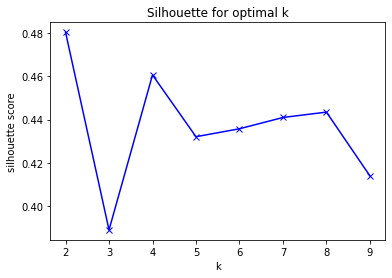

In [ ]:
plt.plot(k_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette for optimal k')
plt.show()

In [ ]:
sqd = []
k = range(2,10)
for i in k:
  kmeans = KMeans(n_clusters=i).fit(df_distance_clusters)
  sqd.append(kmeans.inertia_)

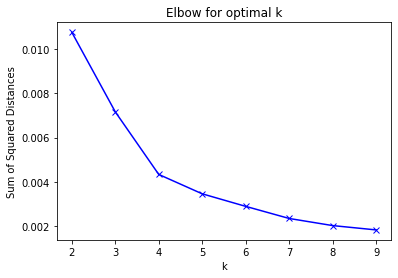

In [ ]:
plt.plot(k, sqd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow for optimal k')
plt.show()

According to the scores above, k=4 would be a good approach to our clustering problem. We will have 4 well defined centroid/clusters, so lets fit the model and plot again:

In [ ]:
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(df_distance_clusters)
kmeans.labels_
df_centro.insert(0, 'clusterlabels', kmeans.labels_)


In [ ]:
print(df_centro.info())
print(df_centro.shape)
df_centro

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clusterlabels  160 non-null    int32 
 1   name           160 non-null    object
 2   latitude       160 non-null    object
 3   longitude      160 non-null    object
 4   distance       160 non-null    object
 5   category       160 non-null    object
dtypes: int32(1), object(5)
memory usage: 7.0+ KB
None
(160, 6)


,clusterlabels,name,latitude,longitude,distance,category
0,1,Mr. Fit Fast Food Saudável,-22.91,-43.1712,728,Food
1,0,Joe's Pub Food Truck,-22.9266,-43.1766,2180,Food
2,1,Vou Street Food,-22.9147,-43.1664,491,Food
3,0,Kitchen Asian Food,-22.9203,-43.1705,1248,Food
4,1,Mix Folhas Fresh Food,-22.9051,-43.1738,1164,Food
...,...,...,...,...,...,...
155,2,ibis Budget Hotel,-22.9073,-43.1819,1855,Hotel
156,0,Mengo Palace Hotel,-22.9285,-43.1752,2283,Hotel
157,2,Fluminense Hotel,-22.9129,-43.1847,2119,Hotel
158,2,HOTEL Champagne,-22.9112,-43.191,2752,Hotel


In [ ]:
colors={0:'red',1:'blue',2:'green',3:'purple',4:'orange'}

map_centro_cluster = folium.Map(location=[airport_lat, airport_lon],zoom_start=15)

for lat, lon, clusters, name in zip(df_centro['latitude'],df_centro['longitude'],df_centro['clusterlabels'],df_centro['name']):
    label = '{}'.format(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        color=colors[clusters],
        fill_color=colors[clusters],
        fill_opacity=0.5
        ).add_to(map_centro_cluster)

map_centro_cluster

## **5 - Clean visuals for our clusters & final mapping**<a name="visuals"></a>


We want this map to be easier to be more intuitive, and Font Awesome icons with Folium marker can help us with that. For that we'll need to make one more adjustment on our data. First we'll change the type of the column 'category' and then capture their codes:

In [ ]:
df_centro = df_centro.astype({"category":'category'})
df_centro['category-id'] = df_centro['category'].cat.codes
df_centro = df_centro.astype({"category-id":'int'})

In [ ]:
print(df_centro.info())
print(df_centro.shape)
df_centro.head(60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   clusterlabels  160 non-null    int32   
 1   name           160 non-null    object  
 2   latitude       160 non-null    object  
 3   longitude      160 non-null    object  
 4   distance       160 non-null    object  
 5   category       160 non-null    category
 6   category-id    160 non-null    int64   
dtypes: category(1), int32(1), int64(1), object(4)
memory usage: 7.4+ KB
None
(160, 7)


,clusterlabels,name,latitude,longitude,distance,category,category-id
0,1,Mr. Fit Fast Food Saudável,-22.91,-43.1712,728,Food,2
1,0,Joe's Pub Food Truck,-22.9266,-43.1766,2180,Food,2
2,1,Vou Street Food,-22.9147,-43.1664,491,Food,2
3,0,Kitchen Asian Food,-22.9203,-43.1705,1248,Food,2
4,1,Mix Folhas Fresh Food,-22.9051,-43.1738,1164,Food,2
5,1,Rildy Carioca Food,-22.9058,-43.1748,1219,Food,2
6,1,Cogu Food Truck,-22.917,-43.1736,1186,Food,2
7,1,Assima - Fast food CMRJ,-22.9098,-43.1763,1251,Food,2
8,1,Farani Fresh Food,-22.9072,-43.1783,1495,Food,2
9,1,Marley's Coisinhas Food Truck,-22.903,-43.1737,1298,Food,2


In [ ]:
icons={0:'fa-coffee', 1:'fa-glass', 2:'fa-cutlery', 3:'fa-h-square', 4:' fa-university'}

centro_marker = folium.Map(location=[airport_lat, airport_lon],zoom_start=15)

for latitude, longitude, name, clusters, category in zip(df_centro['latitude'],df_centro['longitude'],df_centro['name'], df_centro['clusterlabels'], df_centro['category-id']):
    label = '{}, Região {}'.format(name, clusters)
    folium.Marker(
        [latitude, longitude],
        popup=label,
        icon=folium.Icon(color=colors[clusters],icon=icons[category], prefix='fa')
        ).add_to(centro_marker)

centro_marker

To make our final analysis easier, we can check how many different venues we have in each cluster, using GroupBy to create a new dataframe:

In [ ]:
count_clusters = df_centro.groupby(['clusterlabels','category']).count()
count_clusters = count_clusters['category-id']
count_clusters = pd.DataFrame(count_clusters)
count_clusters.reset_index(inplace = True)
count_clusters = count_clusters.pivot_table(index = 'clusterlabels', columns ='category', values ='category-id')

In [ ]:
count_clusters

category,Coffee,Drinks,Food,Hotel,Museu
clusterlabels,,,,,
0,4,3,5,10,8
1,6,13,13,8,7
2,3,17,3,9,12
3,6,12,9,3,9


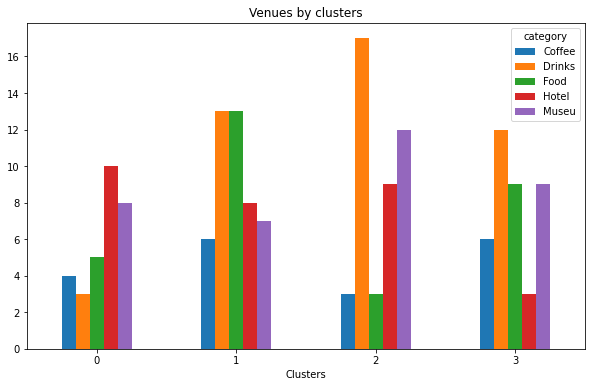

In [ ]:
count_clusters.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Clusters') # add to x-label to the plot
#plt.ylabel('') # add y-label to the plot
plt.title('Venues by clusters') # add title to the plot
plt.xticks(rotation=0)

plt.show()

## **6 - What can we understand from the data?**<a name="conclusion"></a>


Our analysis shows that, while we have some options all around the neighborhood, some of the venues really concentrate in a few areas, while other presents good oportunities for new businesses.

In [ ]:
centro_marker

- Zone 0 (red markers on the map), the nearest to the airport, is a well-balanced region, with good amount of different venues and activities, which could be an interesting option for a traveler who doesn't have a lot of time and wishes to visit a couple of interesting places on foot.
- Zone 1 (blue markers on the map) is the less crowded overall, but maybe that's because its located on the edge of Rio's Centro, and closer to the Zona Sul (South Zone), where some of the most famous beaches and neighborhoods like Copacabana are located. It could be a great option for those who are willing to travel a bit far and enjoy more of the City.
- Zone 2 (green markers on the map) has the most options of bars (17) and museums (12), while severely lacking on food (3) and coffee shop (3) options. This could mean a hotspot for tourists who would prefer a busy evening and lots of activities in the nigh life.
- Zone 3 (purple markers on the map) is a well-balanced area for activities, with a bit of everything, but one may find the hotel choices in the area a bit restrictive, as there are only 3 options to choose from.


Our clusters also could help a potential investor find good spots for opening new businesses. As an example, Zone 2, the one that has the most variety of museums and nightlife, could really use more options of restaurants or food trucks.

#### 6.1 - Conclusion
The purpose of this project was to map venues around Rio de Janeiro's Centro and provide a general overview to tourists coming to the city, so they would be able to make well-informed choices regarding their stay and based on their personal interests. The data gathered could also be used to indicate hotspots with bigger demand for potential new businesses around the neighborhood. For further projects, we could implement a recommender system that would allow the user to choose, via a web interface their prefered spots and receive custom suggestions for hotels and interesting venues.